# Skin Cancer Classify MONAI Pytorch

## Install MONAI

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
pip install fastai==2.7.1


Note: you may need to restart the kernel to use updated packages.


In [3]:
import fastai
fastai.__version__

'2.7.1'

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

## Read image filenames from the dataset folders

Ok, so we have a "training" directory, called train_dir:

In [5]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [6]:
#train
class_names0 = os.listdir(train_dir)
print(class_names0)
print('\n')
input('these are the directories in `train_dir` : and also the classes\n')
class_names = sorted(class_names0)
print(class_names)
print(len(class_names))
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis', 'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis', 'dermatofibroma', 'nevus']




these are the directories in `train_dir` : and also the classes
 


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


Ok, let's load this into a fastai style dataloader. This might take several days, but it is doable. Also great practise on FastAI basics anyway. 

In [7]:
#FastAI import here as needed
from fastai.vision.all import *

In [ ]:
path=get_image_files(train_dir)#, recurse=True, folders=None)
fnames = [i.as_posix() for i in path]

#Now we need a labeller...

print(fnames[0])
print(path[0])

In [8]:
#Nothing is final here: we are just hacking and exploring. Will modify as times goes on

path=get_image_files(train_dir)#, recurse=True, folders=None)
class_names = [i.as_posix() for i in path]

import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None
    
class_names = [extract_text(i) for i in class_names]

In [9]:
#This cell is "working" so leave here for now
fnames = get_image_files(train_dir)

def label_func(x): return extract_text(x.as_posix())



dls = ImageDataLoaders.from_path_func(train_dir, fnames, label_func,
                                      item_tfms=Resize(224),
                                      valid_pct=0,
                                    )

train_dls = dls.train

x,y = dls.one_batch()

In [10]:
#Compute the mean and standard deviation of the dataset
def compute_mean_std(dls):
    # Initialize variables to store the sum and sum of squares of the data
    channel_sum = [0, 0, 0]
    channel_sum_squares = [0, 0, 0]

    # Iterate over the data in the dataloader
    for data,y in dls:
        
        batch_size, _, height, width = data.shape

        # Compute the sum and sum of squares of the data for each channel
        for channel in range(3):
            channel_sum[channel] += data[:, channel, :, :].sum()
            channel_sum_squares[channel] += (data[:, channel, :, :] ** 2).sum()

    # Calculate the number of elements in the data
    num_elements = batch_size * height * width * len(dls)

    # Calculate the mean and standard deviation for each channel
    means = [channel_sum[i] / num_elements for i in range(3)]
    stddevs = [((channel_sum_squares[i] / num_elements) - means[i]**2)**0.5 for i in range(3)]

    return means, stddevs


# Example usage
means, stddevs = compute_mean_std(train_dls)
print("Means:", means)
print("Standard deviations:", stddevs)

Normalize.from_stats(mean=means,std=stddevs)

Means: [TensorImage(0.7481), TensorImage(0.5841), TensorImage(0.5837)]
Standard deviations: [TensorImage(0.1274), TensorImage(0.1446), TensorImage(0.1624)]


Normalize -- {'mean': tensor([[[[0.7481]],

         [[0.5841]],

         [[0.5837]]]]), 'std': tensor([[[[0.1274]],

         [[0.1446]],

         [[0.1624]]]]), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
(Tabular,object) -> encodes
decodes: (TensorImage,object) -> decodes
(Tabular,object) -> decodes

In [11]:
#Normalize.from_stats(mean=means,std=stddevs,dim=1) can use this guy later
item_tfms = [Resize(224)]
dls = ImageDataLoaders.from_path_func(train_dir, fnames, label_func,item_tfms=item_tfms
                                    )
x,y = dls.one_batch()

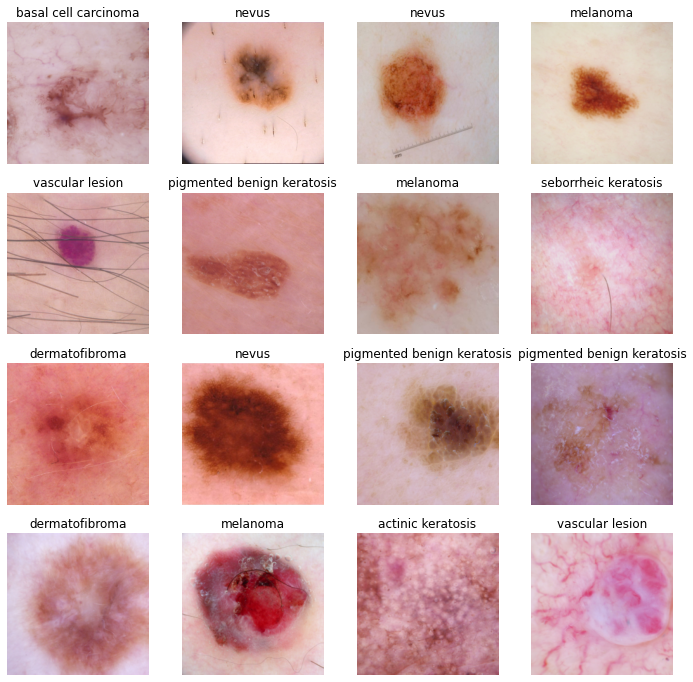

In [19]:
dls.show_batch(max_n=16)

In [12]:
x, y = dls.one_batch()
for label in y:
    print(dls.vocab[label])

vascular lesion
basal cell carcinoma
melanoma
vascular lesion
nevus
basal cell carcinoma
pigmented benign keratosis
pigmented benign keratosis
squamous cell carcinoma
nevus
basal cell carcinoma
vascular lesion
squamous cell carcinoma
squamous cell carcinoma
actinic keratosis
basal cell carcinoma
pigmented benign keratosis
actinic keratosis
melanoma
squamous cell carcinoma
pigmented benign keratosis
basal cell carcinoma
basal cell carcinoma
vascular lesion
actinic keratosis
vascular lesion
actinic keratosis
pigmented benign keratosis
pigmented benign keratosis
actinic keratosis
pigmented benign keratosis
pigmented benign keratosis
dermatofibroma
melanoma
basal cell carcinoma
pigmented benign keratosis
melanoma
pigmented benign keratosis
pigmented benign keratosis
dermatofibroma
actinic keratosis
basal cell carcinoma
melanoma
pigmented benign keratosis
nevus
melanoma
dermatofibroma
vascular lesion
nevus
basal cell carcinoma
pigmented benign keratosis
basal cell carcinoma
nevus
melanoma
n

In [ ]:
valid_frac = 0.2
trainX,trainY = [],[]
valX,valY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX))

In [ ]:
#test
t_class_names0 = os.listdir(test_dir)
t_class_names = sorted(t_class_names0)
print(t_class_names)
t_num_class = len(t_class_names)
t_image_files = [[os.path.join(test_dir, t_class_name, x) 
               for x in os.listdir(os.path.join(test_dir, t_class_name))] 
               for t_class_name in t_class_names]

t_image_file_list = []
t_image_label_list = []
for i, class_name in enumerate(t_class_names):
    t_image_file_list.extend(t_image_files[i])
    t_image_label_list.extend([i] * len(t_image_files[i]))
      

## Visualise some examples

In [17]:
im = Image.open(image_file_list[0])
print(im)

print(len(image_file_list))


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F61143B0F10>
2239


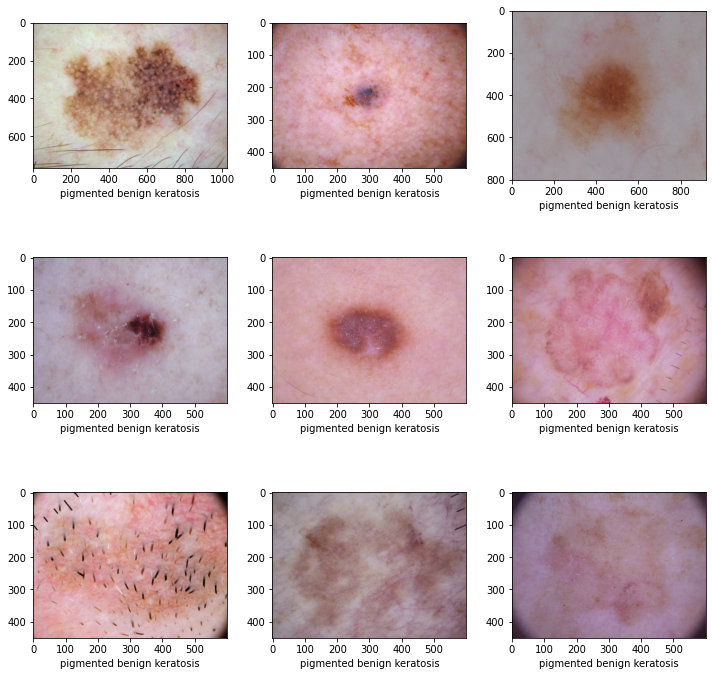

In [18]:
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    #print(arr.shape)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()
# image size and number of channels differ each other

## Prepare training, validation and test data lists

In [ ]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(t_image_file_list)
testY=np.array(t_image_label_list)

In [ ]:
trainX

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [ ]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [ ]:
class MyResize(Transform):
    def __init__(self, size=(150,200)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [ ]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

test_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class, n_classes=num_class)

In [ ]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [ ]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(testX, testY, test_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

In [ ]:
device = torch.device("cuda:0")   #"cuda:0"
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 80
val_interval = 1

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())     ##### 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images.float())], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


## Plot the loss and metric

In [ ]:
plt.figure('train', (12,6))
plt.subplot(1,2,1)
plt.title("Epoch Average Loss")
x = [i+1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1,2,2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i+1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x,y)
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(val_images.float()).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(val_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [ ]:
t_y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images.float()).argmax(dim=1)
        for i in range(len(pred)):
            t_y_pred.append(pred[i].item())

In [ ]:
t_num_total=len(t_image_file_list)
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(t_num_total, size=9)):
    im = Image.open(t_image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[t_y_pred[i]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()